See [here](https://medium.com/bigdatarepublic/contextual-changepoint-detection-with-python-and-r-using-rpy2-fa7d86259ba9)

## An example: Truck Fuel Consumption Monitoring

In [9]:
import numpy as np
import pandas as pd

In [10]:

# data generation functions
def normalize(x):
    mu = np.mean(x)
    sigma = np.std(x)
    return np.array([(elem - mu)/float(sigma) for elem in x])

def generate_data(n_obs, changepoint_time):    
    # Features
    day = np.arange(1, n_obs + 1)
    weight_kg = np.random.normal(5000, 500, n_obs)
    area = ['city'] * round((n_obs / 4)) + ['countryside'] * round((n_obs / 4)) + ['city'] * round((n_obs / 4)) + ['countryside'] * round((n_obs - 3 * (n_obs / 4)) + 1)
    headwind = np.random.choice(['No', 'Weak', 'Moderate', 'Strong'], n_obs)
    X =  pd.DataFrame({'day': day, 'weight_kg': weight_kg, 'area': area, 'headwind': headwind})    
    
    # Target
    X['l_100km'] = 30 + normalize(X['weight_kg']) * 2.1 + \
                        np.array([ item for item in map(float, X['area'] == 'city') ]) * 3.5 + \
                        X['headwind'].map({'No': 1, 'Weak': 2, 'Moderate': 3, 'Strong': 4}) + \
                        np.random.normal(0, 7) + \
                        X.day.map(lambda x: float(x > changepoint_time) * (x - changepoint_time) * 0.02)
                        
    return X

In [11]:
np.random.seed(25)
df_truck = generate_data(365, 300)
df_truck.head()

,day,weight_kg,area,headwind,l_100km
0,1,5114.136545,city,Moderate,34.830780
1,2,5513.445152,city,No,34.400501
2,3,4580.207576,city,Strong,33.731852
3,4,4704.409241,city,Moderate,33.220101
4,5,4521.555852,city,No,30.501287


In [12]:
y = df_truck['l_100km']
X = df_truck[['area', 'headwind', 'weight_kg']]

In [13]:
X_train, y_train = map(lambda x: x[:265], [X, y])
X_test, y_test = map(lambda x: x[265:], [X, y])

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.ensemble import RandomForestRegressor

def get_categorical_glossary(x):
    n_unique = len(np.unique(x[x.notnull()]))
    codes = range(0, n_unique)
    return dict(zip(np.unique(x), codes))

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Selects columns by name
    """    
    def __init__(self, colnames):
        self.colnames = colnames

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.colnames]
    
class NumericEncoder(BaseEstimator, TransformerMixin):
    """
    Replaces categoricals with integer indices.
    We need this since the default scikit-learn LabelEncoder is not supported in Pipelines.
    """
    def fit(self, X, y=None):
        self.glossary = dict([(nm, get_categorical_glossary(X[nm])) for nm in X])
        return self

    def transform(self, X, y=None):
        X_new = X.copy()
        for nm in X:
            # if missing in dict, sets to NaN
            X_new[nm] = X[nm].map(self.glossary[nm])
        return X_new

In [15]:
# Numeric variables
numeric_pipeline = make_pipeline(ColumnSelector(['weight_kg']))

# Categorical variables
categorical_pipeline = make_pipeline(ColumnSelector(['area', 'headwind']), NumericEncoder())

# Combining numerical and categorical data preprocessing
preproc_union = make_union(numeric_pipeline, categorical_pipeline)

# Final pipeline
estimation_pipeline = make_pipeline(preproc_union, RandomForestRegressor(n_estimators=100))

# Fit the pipeline!
estimation_pipeline.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(colnames=['weight_kg']))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(colnames=['area',
                                                                                           'headwind'])),
                                                                 ('numericencoder',
                                                                  NumericEncoder())]))])),
                ('randomforestregressor', RandomForestRegressor())])

In [16]:
y_test_predictions = estimation_pipeline.predict(X_test)
prediction_errors = y_test - y_test_predictions

<AxesSubplot:>

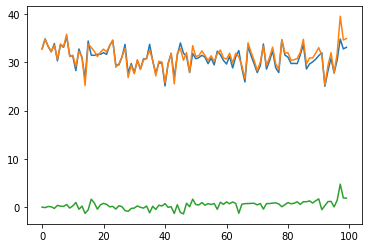

In [17]:
pd.Series(y_test_predictions).plot()
pd.Series(y_test_predictions + prediction_errors.to_list()).plot()
pd.Series(prediction_errors.to_list()).plot()


In [ ]:
#!pip install rpy2

In [18]:
# Using R inside python
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# Install packages
packnames = ('cpm')
utils.install_packages(StrVector(packnames))

R[write to console]: Installing packages into 'C:/Users/russe/OneDrive/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



<rpy2.rinterface_lib.sexp.NULLType object at 0x000001BE16165EC0> [RTYPES.NILSXP]

In [19]:
# Load packages
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

# Function to convert an R object to a Python dictionary
def robj_to_dict(robj):
    return dict(zip(robj.names, map(list, robj)))

In [20]:
cpm = importr('cpm')

In [21]:
cpm_result = cpm.detectChangePoint(FloatVector(prediction_errors), cpmType='Student', ARL0=1000)
cpm_result = robj_to_dict(cpm_result)

In [23]:
cpm_result

{'x': [-0.05091888879994144,
  -0.14382538170122672,
  0.08661611780055267,
  0.01983080116697522,
  -0.31524372430385483,
  0.321567794093486,
  0.15955764742784595,
  0.10535165960227033,
  0.4985967141532086,
  -0.23864368299491545,
  0.20808748553050194,
  0.9180422175386909,
  -0.4858811922212496,
  0.1562987347514131,
  -1.3445912648251053,
  -0.613408617850844,
  1.5951591937375014,
  0.8299023857876087,
  -0.4764832805976411,
  0.4360924991839248,
  0.7387188113634906,
  0.5320601425248128,
  0.014157642886637234,
  0.11158565564058875,
  -0.4430003793459001,
  0.2407171480145749,
  0.04561257529404372,
  -0.7781035670003789,
  -0.9184982846976517,
  -0.3224073158770082,
  -0.24282030760659623,
  0.19774552595432127,
  -0.0752842626118877,
  -0.25264913817165535,
  0.18483084362969038,
  -1.2262662779142843,
  0.13428056223580853,
  -0.5227436534823262,
  0.3555157470850183,
  0.18708375841778846,
  0.6780960051790998,
  -0.08875591448068576,
  0.04065630187153957,
  -1.3585629

In [26]:
import matplotlib.pyplot as plt 

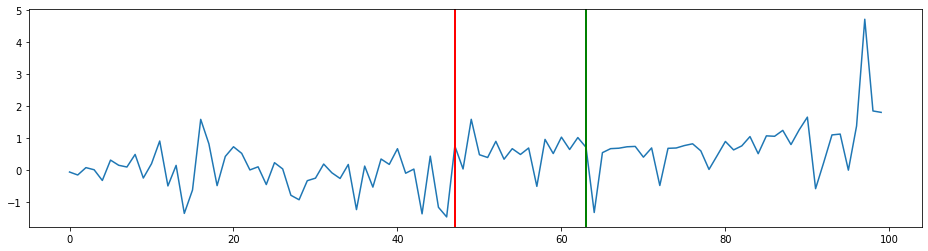

In [28]:

plt.figure(figsize=(16,4))
plt.plot(cpm_result['x'])
for x in cpm_result['changePoint']:
    plt.axvline(x,lw=2, color='red')
for x in cpm_result['detectionTime']:
    plt.axvline(x,lw=2, color='green')